# **Import libraries**

In [46]:

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


# **Download dataset**

In [47]:

import kagglehub
dataset = kagglehub.dataset_download('ashishsaxena2209/animal-image-datasetdog-cat-and-panda')

print('Images download done.')


Images download done.


# **Access Images**

In [48]:

print(os.listdir(dataset))

['animals', 'images']


In [49]:
dataset = os.path.join(dataset, "animals")
print(os.listdir(dataset))

['animals', 'images', 'dogs', 'panda', 'cats']


In [50]:
dataset = os.path.join(dataset, "animals")
print(os.listdir(dataset))

['dogs', 'panda', 'cats']


In [51]:
categories = os.listdir(dataset)
print(categories)

['dogs', 'panda', 'cats']


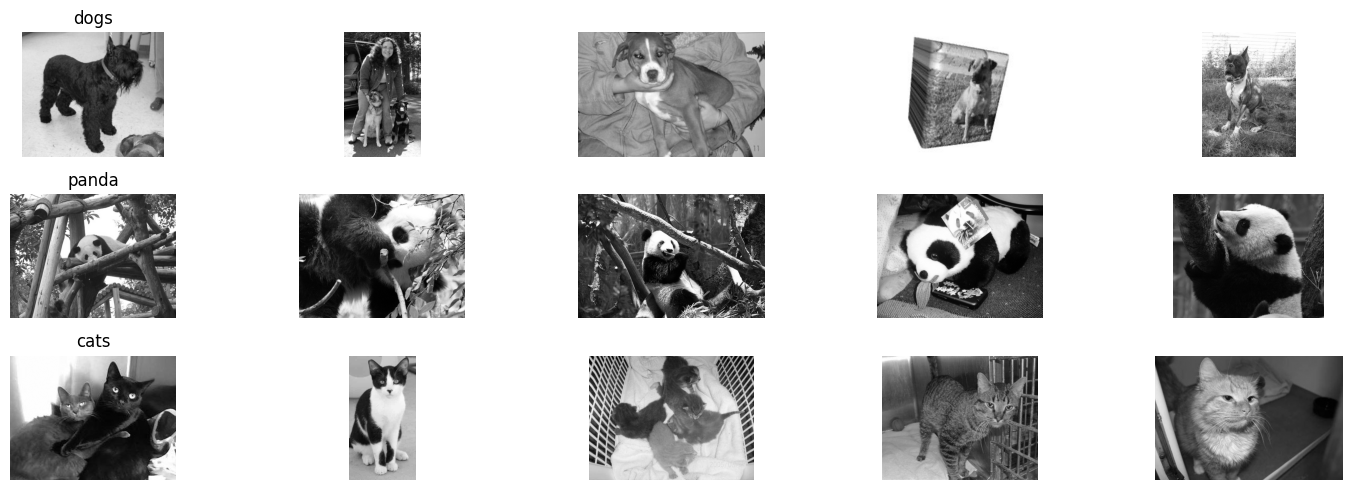

In [52]:

# Number of images to show per category
num_images = 5

# Set figure size
plt.figure(figsize=(15, 5))

# Loop through each category
for idx, category in enumerate(categories):  # ['dogs', 'panda', 'cats']
    category_path = os.path.join(dataset, category)
    images = os.listdir(category_path)[:num_images]  # Pick first few images

    for i, img_name in enumerate(images):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(len(categories), num_images, idx * num_images + i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(category if i == 0 else "")  # Show label once per row

plt.tight_layout()
plt.show()


# **Randomly choose 100 pics**

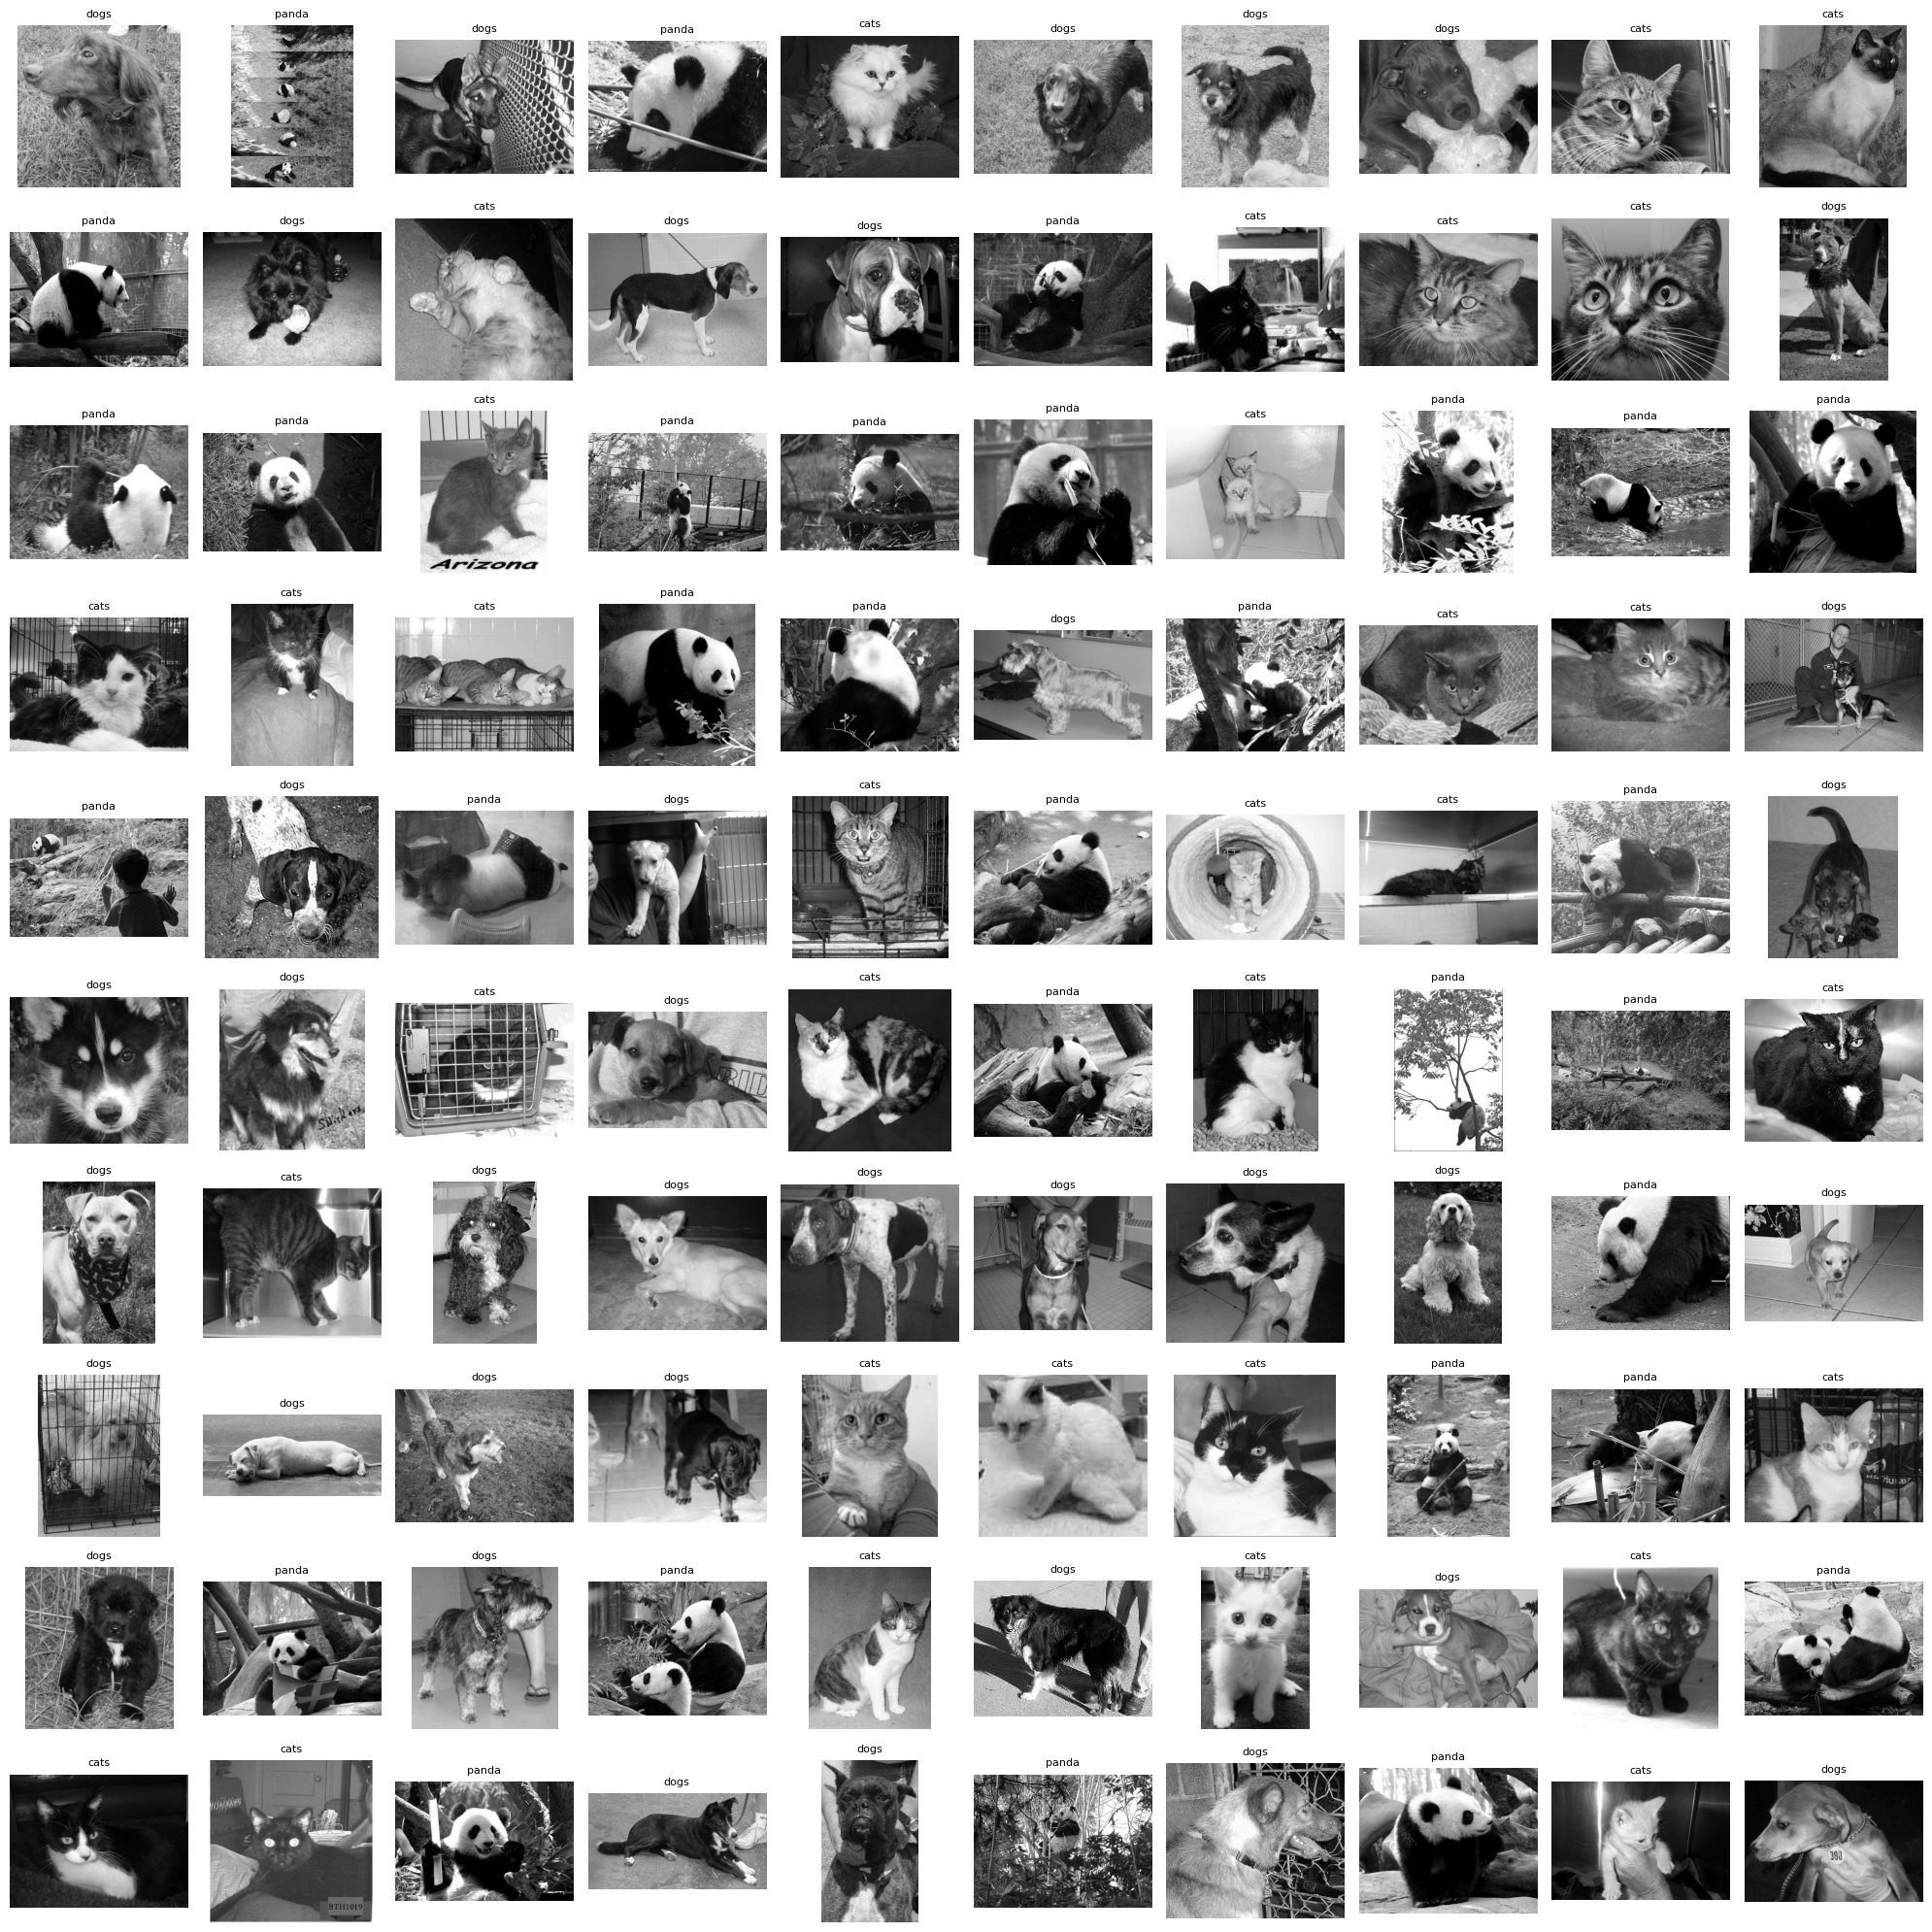

In [53]:

# Collect all image paths with labels
all_images = []

for label, category in enumerate(categories):  # categories = ['dogs', 'panda', 'cats']
    category_path = os.path.join(dataset, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        all_images.append((img_path, category))

# Shuffle and pick 100 random images
import random
random.shuffle(all_images)
sample_images = all_images[:100]

# Display 100 images (10x10 grid)
plt.figure(figsize=(20, 20))
for i, (img_path, label) in enumerate(sample_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(10, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Category names to numeric labels**

In [54]:

# Convert category names to numeric labels
label_map = {'cats': 0, 'dogs': 1, 'panda': 2}

X = []
y = []

for img_path, label_str in sample_images:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (32, 32))
    X.append(img_resized.flatten())
    y.append(label_map[label_str])

X = np.array(X)
y = np.array(y)


# **Defining Euclidean and Manhattan distance functions**

In [55]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))


In [56]:
from collections import Counter

def knn_predict(X_train, y_train, x_test, k, distance_func):
    distances = []
    for i in range(len(X_train)):
        dist = distance_func(X_train[i], x_test)
        distances.append((dist, y_train[i]))

    distances.sort(key=lambda x: x[0])
    top_k = [label for _, label in distances[:k]]
    prediction = Counter(top_k).most_common(1)[0][0]
    return prediction


# **5-fold cross validation**

In [57]:
def five_fold_cv(X, y, k_values, distance_func):
    fold_size = len(X) // 5
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    accuracies_per_k = {k: [] for k in k_values}

    for fold in range(5):
        start = fold * fold_size
        end = start + fold_size
        val_idx = indices[start:end]
        train_idx = np.concatenate((indices[:start], indices[end:]))

        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        for k in k_values:
            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k, distance_func)
                if pred == y_val[i]:
                    correct += 1
            acc = correct / len(X_val)
            accuracies_per_k[k].append(acc)

    avg_accuracies = {k: np.mean(acc_list) for k, acc_list in accuracies_per_k.items()}
    return avg_accuracies


Average Accuracy for k=1 (L1): 0.39
Average Accuracy for k=1 (L2): 0.43
Average Accuracy for k=3 (L1): 0.37
Average Accuracy for k=3 (L2): 0.43
Average Accuracy for k=5 (L1): 0.39
Average Accuracy for k=5 (L2): 0.37
Average Accuracy for k=7 (L1): 0.37
Average Accuracy for k=7 (L2): 0.43
Average Accuracy for k=9 (L1): 0.38
Average Accuracy for k=9 (L2): 0.49
Average Accuracy for k=11 (L1): 0.38
Average Accuracy for k=11 (L2): 0.50
Average Accuracy for k=13 (L1): 0.34
Average Accuracy for k=13 (L2): 0.52
Average Accuracy for k=15 (L1): 0.37
Average Accuracy for k=15 (L2): 0.51
Average Accuracy for k=17 (L1): 0.32
Average Accuracy for k=17 (L2): 0.47
Average Accuracy for k=19 (L1): 0.34
Average Accuracy for k=19 (L2): 0.50


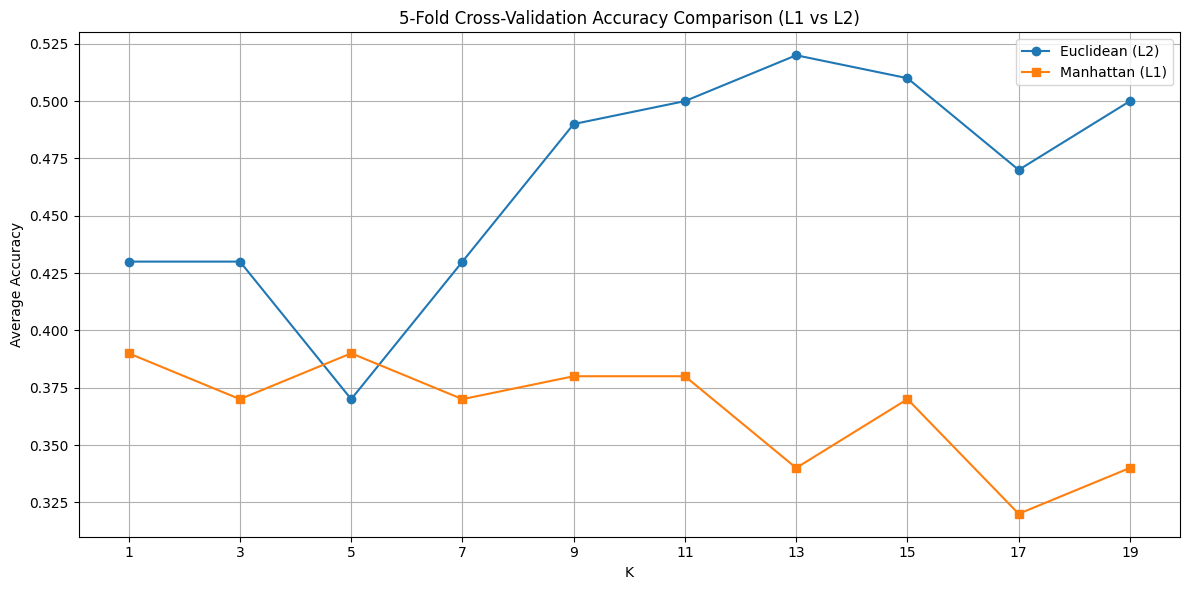

In [58]:
import matplotlib.pyplot as plt

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

# Calculate the average accuracies using 5-fold cross-validation
avg_l2 = five_fold_cv(X, y, k_values, euclidean_distance)  # Call five_fold_cv for L2
avg_l1 = five_fold_cv(X, y, k_values, manhattan_distance)  # Call five_fold_cv for L1

# Now you can print and plot the results:
for k in k_values:
    print(f"Average Accuracy for k={k} (L1): {avg_l1[k]:.2f}")
    print(f"Average Accuracy for k={k} (L2): {avg_l2[k]:.2f}")

# Plot the results of L1 and L2 accuracies side by side
plt.figure(figsize=(12, 6))  # Set a larger figure size for better visibility

plt.plot(k_values, [avg_l2[k] for k in k_values], label='Euclidean (L2)', marker='o')
plt.plot(k_values, [avg_l1[k] for k in k_values], label='Manhattan (L1)', marker='s')

plt.xlabel('K')
plt.ylabel('Average Accuracy')
plt.title('5-Fold Cross-Validation Accuracy Comparison (L1 vs L2)')
plt.legend()
plt.grid(True)
plt.xticks(k_values)  # Ensure we display only the k values for ticks on X-axis
plt.tight_layout()
plt.show()


# **Top 5 predictions**

Top 5 predictions:


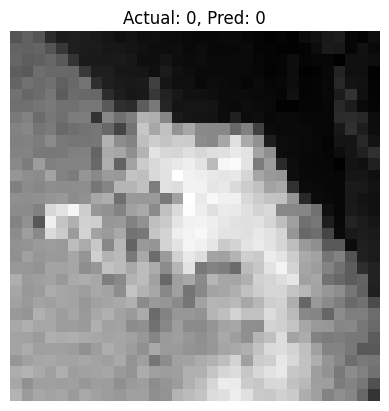

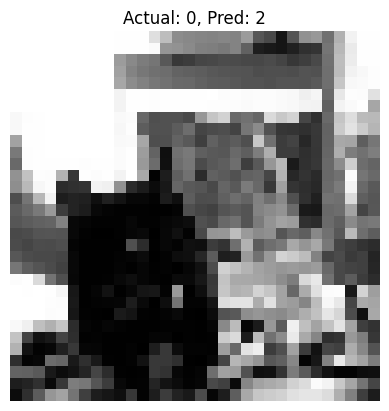

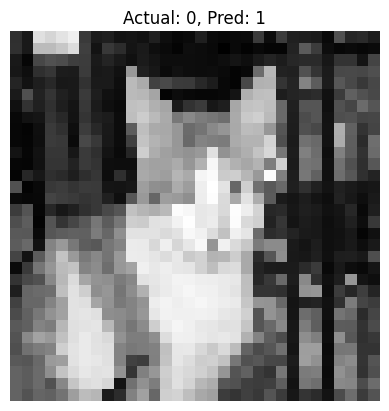

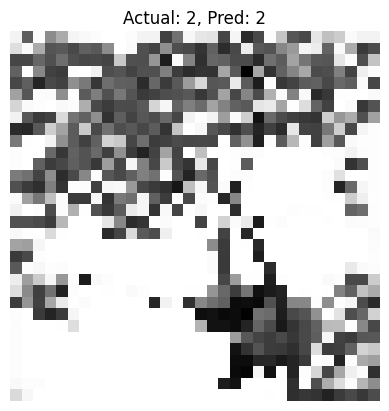

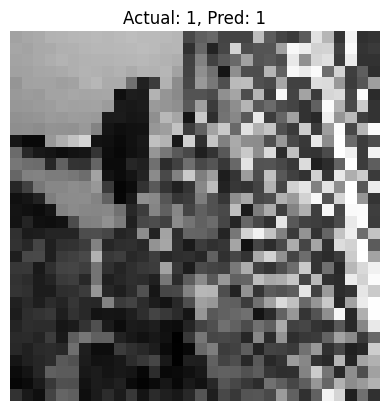

In [59]:
# Random 5 test samples
sample_test_idx = np.random.choice(len(X), 5, replace=False)

print("Top 5 predictions:")
for i in sample_test_idx:
    pred = knn_predict(np.delete(X, i, axis=0), np.delete(y, i), X[i], 3, euclidean_distance)
    actual = y[i]
    plt.imshow(X[i].reshape(32, 32), cmap='gray')
    plt.title(f"Actual: {actual}, Pred: {pred}")
    plt.axis('off')
    plt.show()
